In [23]:
import os
import nibabel as nib
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

In [32]:
def file_to_ndarray(filepath):
    # Check the file extension
    _, file_extension = os.path.splitext(filepath)
    #print(file_extension)
    
    try:
        if file_extension in ['.nii', '.nii.gz', '.gz']:  # Handle gzipped or regular NIfTI files
            # Load the NIfTI file
            nii_img = nib.load(filepath)
            # Convert to ndarray
            data = nii_img.get_fdata()
            #print(f"Loaded NIfTI file: {filepath}")
        else:
            print("Unsupported file format.")
            return None
        
        return data
    
    except Exception as e:
        print(f"An error occurred while processing the file: {e}")
        return None

def fit_gmm(histogram_data, bin_edges):
   # Create dataset by repeating values according to histogram frequencies
   data = []
   for i in range(len(histogram_data)):
       count = int(histogram_data[i])
       if count > 0:
           # Use bin edges to create uniform samples within each bin
           samples = np.random.uniform(bin_edges[i], bin_edges[i+1], count)
           data.extend(samples)
   
   data = np.array(data).reshape(-1, 1)
   
   # Fit GMM
   gmm = GaussianMixture(n_components=2, random_state=0)
   gmm.fit(data)
   
   return gmm.means_.flatten(), gmm.covariances_.flatten()

def rescale_by_probability(image, target_mean, variance):
    """
    Rescale pixel values based on their probability of being the pixel of interest
    under a normal distribution.
    
    Parameters:
    -----------
    image : numpy.ndarray
        Input grayscale image array
    target_mean : float
        The target pixel value (mean of the normal distribution)
    variance : float
        Variance of the normal distribution
    
    Returns:
    --------
    numpy.ndarray
        Rescaled image where each pixel value represents the probability
        of that pixel being the pixel of interest
    """
    # Create a copy to avoid modifying the original
    rescaled = image.copy().astype(float)
    
    # Calculate probability for each pixel value
    probabilities = norm.pdf(rescaled, target_mean, np.sqrt(variance))
    
    # Normalize to [0, 1] range
    probabilities = (probabilities - probabilities.min()) / (probabilities.max() - probabilities.min())

    probabilities[probabilities < 0.8] = 0
    
    # Optional: Convert to uint8 for visualization (0-255)
    rescaled = (probabilities * 255).astype(np.uint8)
    
    return rescaled

def rescale_range(array, a, b):
    """
    Rescale values in range [a,b] to [0,255] based on their position in the range.
    Values outside [a,b] become 0.
    
    Parameters:
    array: np.ndarray - Input array
    a: float - Lower bound of the range
    b: float - Upper bound of the range
    """
    # Create a copy to avoid modifying the original
    result = array.copy()
    
    # Set values outside [a,b] to 0
    result[result < a] = 0
    result[result > b] = 0
    
    # Find values within the range
    mask = (result >= a) & (result <= b)
    
    # Linear rescaling of values in range [a,b] to [0,255]
    result[mask] = ((result[mask] - a) / (b - a)) * 255
    
    return result

mean : [406.16064196 929.99093363], variance : [20530.00616384 25121.60649752]


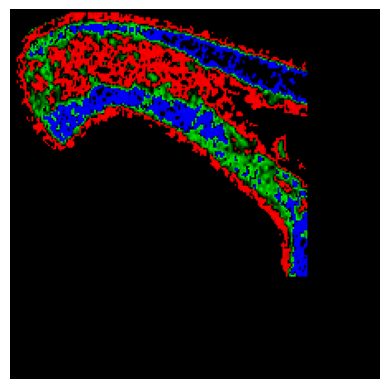

In [33]:
# Load data
filepath = r"C:\Users\acer\Desktop\Data\47-4881 L 2014.nii.gz"
voxel = file_to_ndarray(filepath)

# Compute histogram
flat_array = voxel.flatten()
bins = np.arange(-500, 1500, 1)  # -500 to 1500 size 1

histogram_values, bin_edges = np.histogram(flat_array, bins=bins)
mean, variance = fit_gmm(histogram_values, bin_edges)
print(f"mean : {mean}, variance : {variance}")

slice_2d = voxel[112, :, :]
rescaled_image_air = rescale_by_probability(slice_2d, int(mean[0]), int(variance[0]))
rescaled_image_bone = rescale_by_probability(slice_2d, int(mean[1]), int(variance[1]))

a = mean[0]
b = mean[1]
adjust_const = 0.25
adjust = int((b-a)*adjust_const)
area_of_uncertainty = rescale_range(slice_2d, a+adjust, b-adjust)

red = rescaled_image_air.astype(np.uint8)
green = area_of_uncertainty.astype(np.uint8)
blue = rescaled_image_bone.astype(np.uint8)

# Combine into RGB
rgb_image = np.stack([red, green, blue], axis=2)

# Display the image
plt.imshow(rgb_image)
plt.axis('off')
plt.show()

mean : [406.14643897 929.97311603], variance : [20526.87402523 25125.15641286]


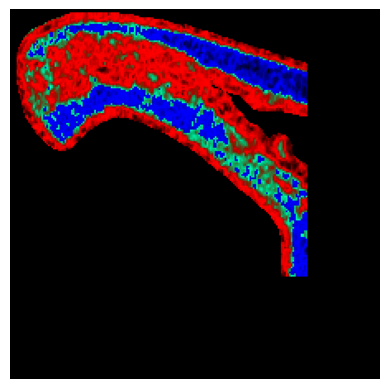

In [31]:
# Load data
filepath = r"C:\Users\acer\Desktop\Data\47-4881 L 2014.nii.gz"
voxel = file_to_ndarray(filepath)

# Compute histogram
flat_array = voxel.flatten()
bins = np.arange(-500, 1500, 1)  # -500 to 1500 size 1

histogram_values, bin_edges = np.histogram(flat_array, bins=bins)
mean, variance = fit_gmm(histogram_values, bin_edges)
print(f"mean : {mean}, variance : {variance}")

slice_2d = voxel[112, :, :]
rescaled_image_air = rescale_by_probability(slice_2d, int(mean[0]), int(variance[0]))
rescaled_image_bone = rescale_by_probability(slice_2d, int(mean[1]), int(variance[1]))

a = mean[0]
b = mean[1]
adjust_const = 0.25
adjust = int((b-a)*adjust_const)
area_of_uncertainty = rescale_range(slice_2d, a+adjust, b-adjust)

red = rescaled_image_air.astype(np.uint8)
green = area_of_uncertainty.astype(np.uint8)
blue = rescaled_image_bone.astype(np.uint8)

# Combine into RGB
rgb_image = np.stack([red, green, blue], axis=2)

# Display the image
plt.imshow(rgb_image)
plt.axis('off')
plt.show()